# 1. Preparation

Load the data and do some process.

In [1]:
import pandas as pd
import numpy as np
from helper_functions import *

RANDOM_SEED = 42

cleaned_df = processing_data(path="C:\\Users\\lee39\\OneDrive\\Desktop\\final_merged_dataset.csv")

C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35489 entries, 0 to 35488
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            35489 non-null  object 
 1   age               35489 non-null  int64  
 2   ethnicity         35489 non-null  object 
 3   admission_type    35489 non-null  object 
 4   event             35489 non-null  int32  
 5   time              35489 non-null  int64  
 6   has_COPD          35489 non-null  float64
 7   has_Diabetes      35489 non-null  float64
 8   has_Metastasis    35489 non-null  float64
 9   has_Sepsis_A41_9  35489 non-null  float64
 10  GCS               35489 non-null  float64
 11  vent              35489 non-null  float64
 12  treatment         35489 non-null  float64
 13  WBC x 1000        35489 non-null  float64
 14  Hgb               35489 non-null  float64
 15  platelets x 1000  35489 non-null  float64
 16  total bilirubin   35489 non-null  float6

In [3]:
categorical_features = ["gender",
                    "ethnicity",
                    "admission_type",
                    "has_COPD",
                    "has_Diabetes",
                    "has_Metastasis",
                    "has_Sepsis_A41_9"]


# 2. DCM on eICU

Process the data so that DCM can be trained on them.

In [4]:
X_data, t_data, e_data, categorical_features_list, numerical_features_list = (
    processing_data_2_DCM(df=cleaned_df,
                          categorical_features_list=categorical_features,
                          train_test_val_size=(0.7, 0.2, 0.1),
                          random_seed=RANDOM_SEED)
)
X_train, X_val, X_test = X_data
t_train, t_val, t_test = t_data
e_train, e_val, e_test = e_data

train_set = (X_train, t_train, e_train)
val_set = (X_val, t_val, e_val)
test_set = (X_test, t_test, e_test)

Define model hyper-parameters.

In [5]:
from sklearn.model_selection import ParameterGrid

DCM_param_grid = {"k" : [3],
                  "learning_rate" : [1e-3],
                  "layers": [[50, 50]],
                  "iters": [100]
             }
DCM_params = ParameterGrid(DCM_param_grid)

Train the DCM.

In [6]:
dcm_wrap = DCM_Wrapper(DCM_params)
dcm_wrap.fit(train_set=train_set, val_set=val_set)
dcm_model = dcm_wrap.model

  0%|          | 0/100 [00:00<?, ?it/s]C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: divide by zero encountered in log
  probs = gates+np.log(event_probs)
 14%|█▍        | 14/100 [00:35<03:36,  2.52s/it]


Find the latent group for the training data

In [7]:
train_latent = dcm_model.predict_latent_z(X_train)

train_group = np.argmax(train_latent, axis=1)
train_group

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Compute propensity score and IPTW

In [8]:
# get the name of covariates exclude the treatment
covariates = list(X_train.columns.drop("treatment_1.0"))

df_ps = pd.concat([X_train, t_train, e_train], axis=1)
df_ps = compute_PS_and_IPTW(df=df_ps,
                            covariates=covariates,
                            treatment="treatment_1.0")

Plot the survival curve and estimate causal using AUC

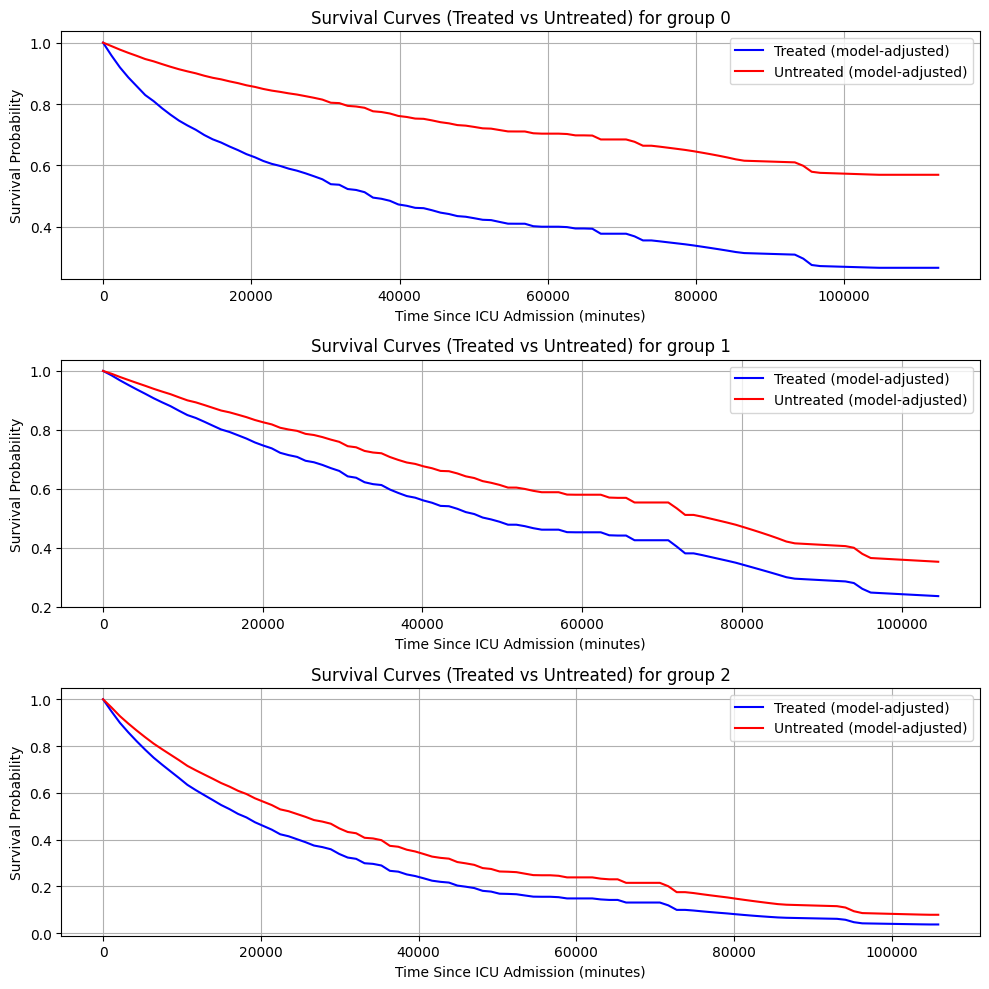

In [9]:
dcm_causal_effects = plot_avg_survival_curve(df=df_ps,
                            group_index=train_group,
                            model_wrapper=dcm_wrap,
                            covariates=covariates,
                            treatment="treatment_1.0"
                            )

In [10]:
print(f"DCM model:")
for i, ce in enumerate(dcm_causal_effects):
    print(f"For group {i}, the estimated causal effect: {ce}.")

DCM model:
For group 0, the estimated causal effect: -30121.038594960744.
For group 1, the estimated causal effect: -10870.535329095714.
For group 2, the estimated causal effect: -8437.189760024074.


# 3. DSM on eICU

In [11]:
# Bug to be fixed
# DSM_param_grid = {"distribution": ["Weibull"],
#                   "k": [3],
#                   "layers": [[50, 50]],
#                   "learning_rate": [1e-3],
#                   "iters": [100]
#              }
# DSM_params = ParameterGrid(DSM_param_grid)

In [12]:
# from auton_survival.models.dsm import DeepSurvivalMachines
#
# dsm_wrap = DSM_Wrapper(DSM_params)
# dsm_wrap.fit(train_set=train_set, val_set=val_set)
# dsm_model = dsm_wrap.model

100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


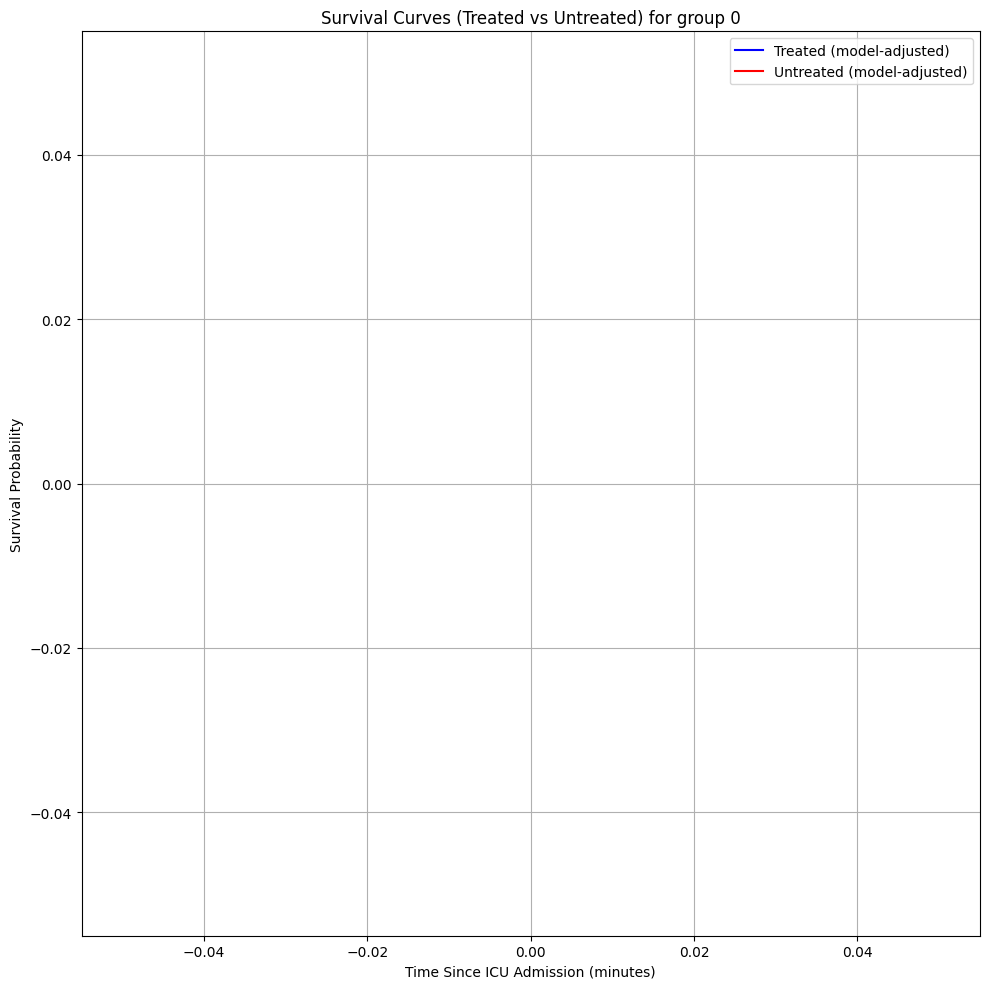

In [13]:
# dsm_causal_effects = plot_avg_survival_curve(df=df_ps,
#                             group_index=np.zeros_like(train_group),
#                             model_wrapper=dsm_wrap,
#                             covariates=covariates,
#                             treatment="treatment_1.0"
#                             )

In [14]:
# print(f"DSM model:")
# for i, ce in enumerate(dsm_causal_effects):
#     print(f"For group {i}, the estimated causal effect: {ce}.")

DSM model:
For group 0, the estimated causal effect: nan.


## 4. Cox Regression on eICU

In [15]:
CR_wrap = Cox_Regression_Wrapper()
CR_wrap.fit(train_set=train_set, val_set=val_set)
CR_model = CR_wrap.model

C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\lifelines\utils\__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


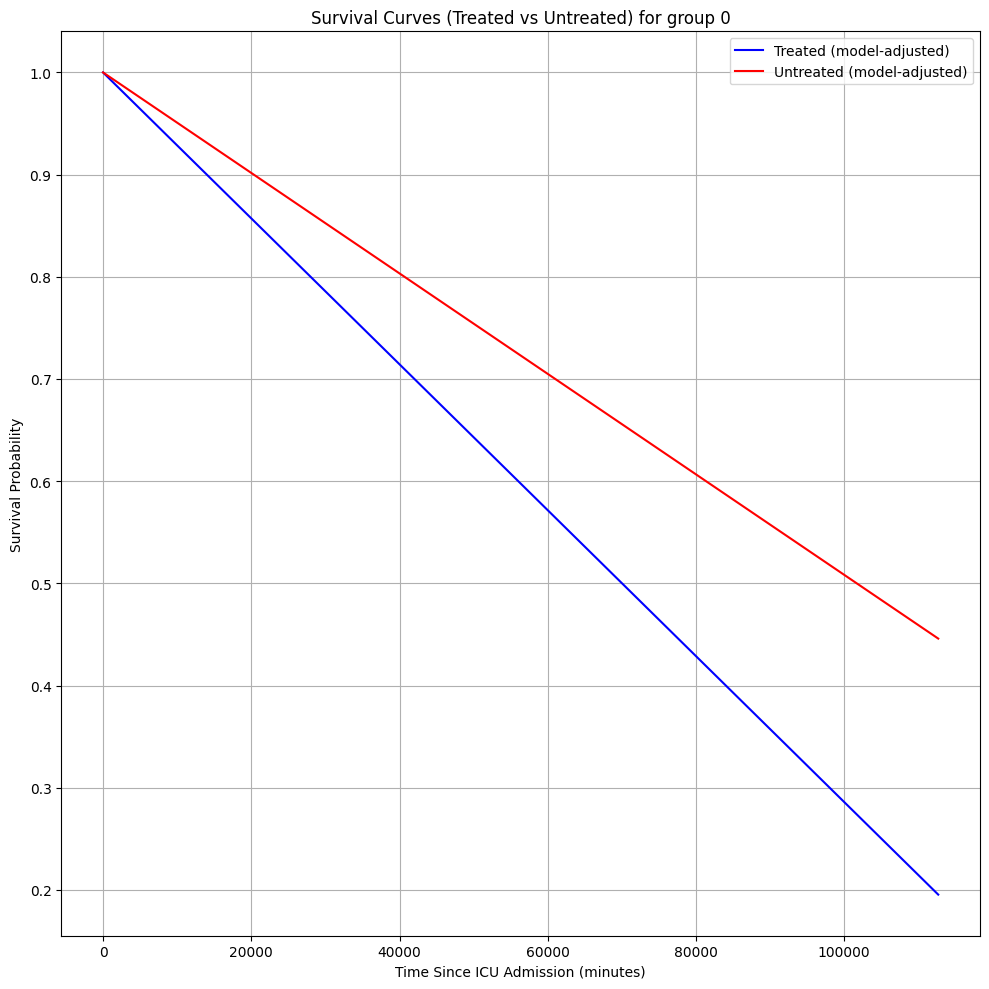

In [19]:
CR_causal_effects = plot_avg_survival_curve(df=df_ps,
                            group_index=np.zeros_like(train_group),
                            model_wrapper=CR_wrap,
                            covariates=covariates,
                            treatment="treatment_1.0"
                            )